In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Make sure that you download 'stopwords' package 

In [19]:
#nltk.download_shell()

In [3]:
df=pd.read_csv('SMSSpamcollection',sep='\t',names=['Type','Message'])

In [4]:
df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.describe()

,Type,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.groupby('Type').describe()

Message                                                               
       count unique                                                top freq
Type                                                                       
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

#### let us find out the length of the messages 

In [7]:
df['msg_len']=df['Message'].apply(len)

In [8]:
df['msg_len'].head()

0    111
1     29
2    155
3     49
4     61
Name: msg_len, dtype: int64

In [9]:
max(df['msg_len'])

910

In [10]:
df[df['msg_len']==910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

<AxesSubplot:ylabel='Frequency'>

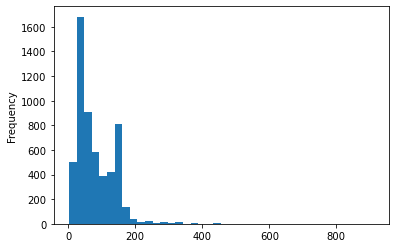

In [11]:
df['msg_len'].plot.hist(bins=40)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

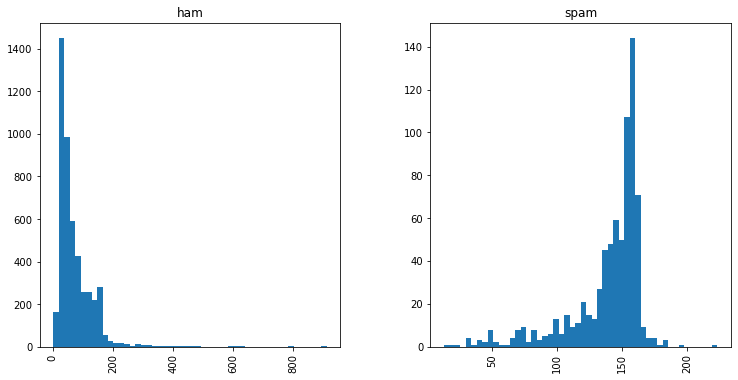

In [12]:
df.hist(column='msg_len',by='Type',figsize=(12,6),bins=50)

##### Its look like spam messages have more length compared to ham

### Now lets create a function that removes pancuations and stopwords,we can use string library to remove pancuations.

In [24]:
import string
from nltk.corpus import stopwords

In [25]:
def cleaning(msg):
    no_punc=[c for c in msg if c not in string.punctuation]
    no_punc=''.join(no_punc)
    return[word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

### Lets see how this function works

In [26]:
df['Message'].head().apply(cleaning)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

### we need to convert text into vectors i.e vectorization

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
bag_of_words=CountVectorizer(analyzer=cleaning).fit(df['Message'])

#### Let us find out how many words are there in our bag_of_words

In [30]:
len(bag_of_words.vocabulary_)

11425

###### lets take a random message and transform it to BOW

In [35]:
msg25=bag_of_words.transform([df['Message'][24]])

In [36]:
msg25.shape

(1, 11425)

In [38]:
print(msg25)

  (0, 1053)	1
  (0, 1905)	1
  (0, 8092)	1
  (0, 9932)	1
  (0, 10979)	1


In [40]:
bag_of_words.get_feature_names()[1053]

'Alright'

In [43]:
msg_bow=bag_of_words.transform(df['Message'])

In [44]:
print(msg_bow.shape)

(5572, 11425)


### Tfidf(Term frequency-inverse document frequency)



In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

In [46]:
tfidf=TfidfTransformer().fit(msg_bow)

In [47]:
tfidf25=tfidf.transform(msg25)

In [48]:
print(tfidf25)

  (0, 10979)	0.32047901337334056
  (0, 9932)	0.5075809704241768
  (0, 8092)	0.3395803486693435
  (0, 1905)	0.5655995811338254
  (0, 1053)	0.4521471674901321


In [52]:
tfidf.idf_[bag_of_words.vocabulary_['love']]

4.773658523649919

In [53]:
msg_tfidf=tfidf.transform(msg_bow)

## Model training

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
spam_detection=MultinomialNB().fit(msg_tfidf,df['Type'])

#### Lets find if our model prediction is correct or not

In [58]:
spam_detection.predict(tfidf25)[0]

'ham'

In [61]:
df['Type'][24]

'ham'

In [60]:
spam_detection.predict(msg_tfidf[45])[0]

'ham'

In [62]:
df['Type'][45]

'ham'

#### Training and testing

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split( df['Message'],df['Type'], test_size=0.3, random_state=42)

In [65]:
X_train

708     Quite late lar... Ard 12 anyway i wun b drivin...
4338                        on a Tuesday night r u 4 real
5029    Go chase after her and run her over while she'...
4921     G says you never answer your texts, confirm/deny
2592         Still work going on:)it is very small house.
                              ...                        
3772    Hi, wlcome back, did wonder if you got eaten b...
5191                               Sorry, I'll call later
5226        Prabha..i'm soryda..realy..frm heart i'm sory
5390                           Nt joking seriously i told
860               Did he just say somebody is named tampa
Name: Message, Length: 3900, dtype: object

In [72]:
from sklearn.pipeline import Pipeline

#### By using pipeline we do not need to repeat all steps ,we just pass the lists we want to do 

In [75]:
pipeline=Pipeline([
                    ('bow',CountVectorizer(analyzer=cleaning)),
                    ('tfidf',TfidfTransformer()),
                    ('classifier',MultinomialNB())
])

In [76]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function cleaning at 0x0000016269AF9550>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [79]:
pre=pipeline.predict(X_test)

In [78]:
from sklearn.metrics import classification_report,confusion_matrix

In [80]:
print(confusion_matrix(y_test,pre))

[[1448    0]
 [  60  164]]


In [81]:
print(classification_report(y_test,pre))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.73      0.85       224

    accuracy                           0.96      1672
   macro avg       0.98      0.87      0.91      1672
weighted avg       0.97      0.96      0.96      1672



### We can try changing the classifiers and check which one has better results